In [111]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers



In [112]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
display(data)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [113]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

In [114]:

def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_values.append(first_value.values) 
        
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    labels = np.array(labels)
    return X, y, first_values, labels



In [115]:
window_size = 30
dataset_size = len(data)
train_size = int(dataset_size * 0.8)
test_size = 30 + window_size 
val_size = dataset_size - train_size - test_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]


X_train, y_train, first_values_train, labels_train = create_X_y_rolling(train_data, binary_targets_train, window_size)
X_val, y_val, first_values_val, labels_val = create_X_y_rolling(val_data, binary_targets_val, window_size)
X_test, y_test, first_values_test, labels_test = create_X_y_rolling(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape


((2696, 30, 33),
 (2696, 33),
 (592, 30, 33),
 (592, 33),
 (30, 30, 33),
 (30, 33),
 (2696, 33),
 (592, 33),
 (30, 33))

In [116]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), 

    LSTM(64, return_sequences=False),
    Dropout(0.2),  

    Dense(y_train.shape[1] )
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

cp = ModelCheckpoint(filepath='model_regression/best_LSTM.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.3522 - mean_squared_error: 0.3521 - val_loss: 0.0078 - val_mean_squared_error: 0.0075
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0599 - mean_squared_error: 0.0599 - val_loss: 0.0061 - val_mean_squared_error: 0.0058
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0048 - val_mean_squared_error: 0.0046
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0051 - val_mean_squared_error: 0.0049
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0048 - val_mean_squared_error: 0.0046
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0054 - val_mean_squared_error: 0.0052
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0

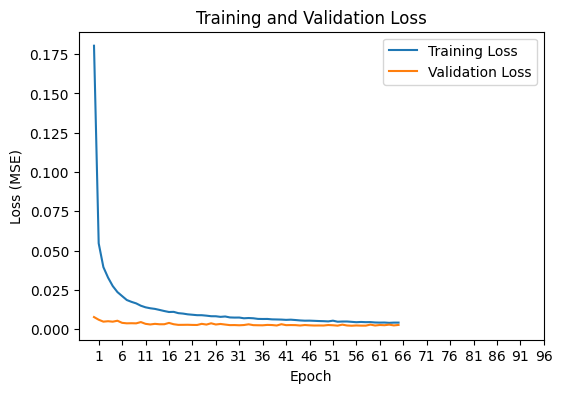

In [117]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [131]:
model = load_model('model_regression/best_LSTM.keras')
index_series = data.index[-len(y_test):]  # Use the last indices for the test set

Y_pred = model.predict(X_test)
Y_pred_denorm = Y_pred * first_values_test  

Predict_result_df = pd.DataFrame(Y_pred_denorm, index=index_series, columns=data.columns)

# display(Predict_result_df)

# Predict_result_df["SPY"].plot()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# Y_pred

array([[1.0241117 , 1.0187385 , 1.0375903 , 1.0441979 , 1.0024985 ,
        1.0541253 , 1.0337324 , 1.0456274 , 1.0311174 , 1.0335097 ,
        1.0362463 , 1.0248864 , 1.0431154 , 1.0478115 , 1.0323281 ,
        1.0499    , 1.0534104 , 1.0396531 , 1.0227569 , 1.061133  ,
        1.0266095 , 1.0194702 , 1.009133  , 1.0739411 , 1.032698  ,
        1.0108387 , 1.0138078 , 1.0339189 , 1.0313429 , 1.039419  ,
        1.048233  , 1.0265652 , 1.0414674 ],
       [1.0299766 , 1.0270542 , 1.0451269 , 1.0386844 , 0.99311733,
        1.0608063 , 1.0384651 , 1.0507381 , 1.0375996 , 1.041613  ,
        1.0415016 , 1.031944  , 1.0492567 , 1.0534399 , 1.0373518 ,
        1.0538528 , 1.0549183 , 1.046088  , 1.0297738 , 1.0695179 ,
        1.0286238 , 1.0237547 , 1.0119274 , 1.0756748 , 1.0399384 ,
        1.0172594 , 0.99948007, 1.0337481 , 1.0371373 , 1.0462494 ,
        1.0554429 , 1.0334601 , 1.0476621 ],
       [1.033183  , 1.0321422 , 1.0503776 , 1.0429685 , 1.0054638 ,
        1.0663531 , 1.0425

In [133]:
# SUMMARY
y_test_denorm = y_test * first_values_test
y_actual = pd.DataFrame(y_test_denorm, index=index_series, columns=data.columns)


mae = mean_absolute_error(y_test, Y_pred)
mse = mean_squared_error(y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, Y_pred)

print("Mean Absolute Error for not normalized:", mae)
print("Mean Squared Error for not normalized:", mse)
print("Root Mean Squared Error for not normalized:", rmse)
print("R² Score (normalized):", r2)

print("===========================")

r2_denorm = r2_score(y_test_denorm, Y_pred_denorm)
mae_denorm = mean_absolute_error(y_test_denorm, Y_pred_denorm)
mse_denorm = mean_squared_error(y_test_denorm, Y_pred_denorm)
rmse_denorm = np.sqrt(mse_denorm)
print("Mean Absolute Error (denormalized):", mae_denorm)
print("Mean Squared Error (denormalized):", mse_denorm)
print("Root Mean Squared Error (denormalized):", rmse_denorm)
print("R² Score (denormalized):", r2_denorm)



Mean Absolute Error for not normalized: 0.0408617399857421
Mean Squared Error for not normalized: 0.003001032425039469
Root Mean Squared Error for not normalized: 0.05478167964784823
R² Score (normalized): -1.5049544498129683
Mean Absolute Error (denormalized): 3.2949170600357394
Mean Squared Error (denormalized): 62.494237138098896
Root Mean Squared Error (denormalized): 7.905329666629906
R² Score (denormalized): -2.9791127711214274


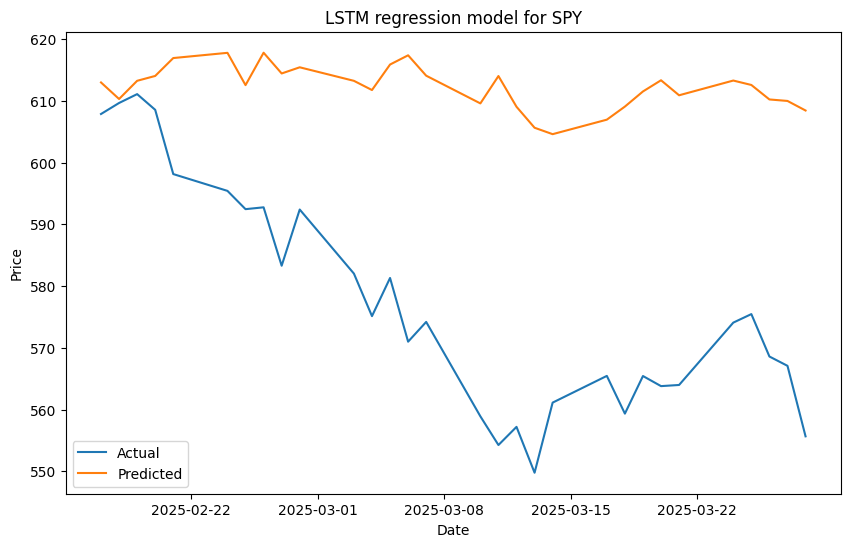

In [121]:
ticker_name = 'SPY'
plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(Predict_result_df[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()

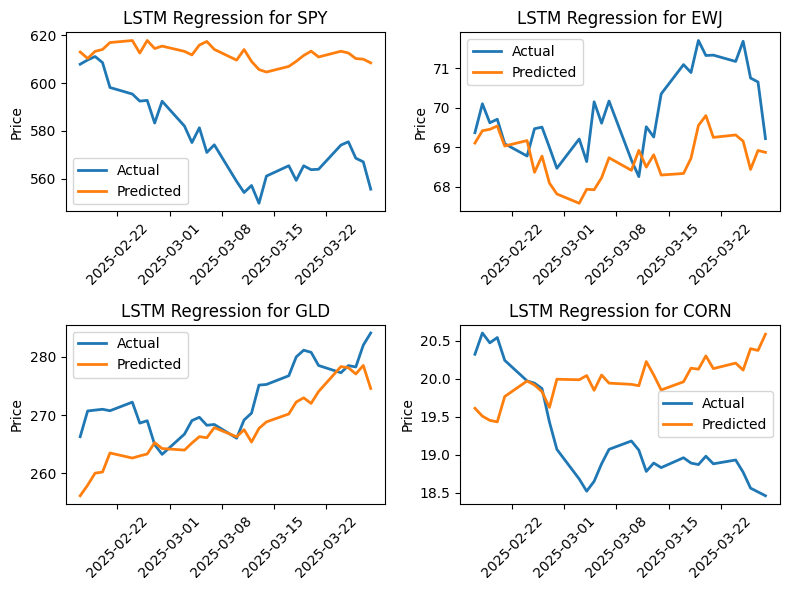

In [130]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Predict_result_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [123]:
data

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [124]:
labels_test_df = pd.DataFrame(labels_test, index=index_series, columns=data.columns)
labels_test_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2025-02-18,1,0,1,1,1,1,1,0,1,1,...,1,1,0,1,1,0,1,1,1,1
2025-02-19,0,1,0,0,1,1,0,0,0,0,...,0,1,1,1,1,1,0,1,0,0
2025-02-20,0,1,0,1,1,1,1,1,0,1,...,1,0,1,1,1,0,1,1,1,1
2025-02-21,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2025-02-24,0,0,0,0,1,1,0,1,0,1,...,0,0,1,1,0,0,0,1,0,1
2025-02-25,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,1,1,0
2025-02-26,1,1,1,0,0,0,1,0,1,1,...,1,1,1,0,0,1,1,0,1,1
2025-02-27,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [125]:
display(labels_test_df["SPY"])

Date
2025-02-17    0
2025-02-18    1
2025-02-19    1
2025-02-20    0
2025-02-21    0
2025-02-24    0
2025-02-25    0
2025-02-26    1
2025-02-27    0
2025-02-28    1
2025-03-03    0
2025-03-04    0
2025-03-05    1
2025-03-06    0
2025-03-07    1
2025-03-10    0
2025-03-11    0
2025-03-12    1
2025-03-13    0
2025-03-14    1
2025-03-17    1
2025-03-18    0
2025-03-19    1
2025-03-20    0
2025-03-21    1
2025-03-24    1
2025-03-25    1
2025-03-26    0
2025-03-27    0
2025-03-28    0
Name: SPY, dtype: int64

In [126]:
Predict_result_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-17,41.609661,10.068624,120.069947,19.610038,14.626453,113.076018,58.747015,25.440113,42.090214,33.351360,...,29.254156,612.983119,86.302479,78.367344,126.654066,150.408348,66.574754,91.617840,73.440162,7.615731
2025-02-18,41.302060,10.173634,117.869412,19.506493,14.648481,112.487898,58.642128,25.448876,42.105792,33.769091,...,29.398191,610.303087,85.871205,78.129355,127.813291,149.443827,67.012237,91.370435,73.635391,7.687221
2025-02-19,41.491596,10.254614,113.860934,19.451362,14.659663,113.033427,58.591490,25.766933,42.581120,33.899207,...,29.682393,613.249116,85.951517,78.508663,128.998817,148.953451,67.092104,91.876204,73.870051,7.656714
2025-02-20,41.534648,10.165256,113.808471,19.431342,14.670522,113.265579,58.666833,25.819874,42.666216,33.966938,...,29.752195,614.035210,86.002763,78.562810,129.158839,149.061946,67.210297,91.977430,74.006208,7.673459
2025-02-21,41.657709,10.206246,113.802292,19.764806,14.925323,114.385219,58.592113,25.594116,42.636464,34.361658,...,30.020181,616.934242,86.775981,78.852196,130.195004,149.429022,67.772347,91.549757,73.619853,7.730277
2025-02-24,41.570573,10.283697,111.897013,19.968526,14.895764,113.970714,58.107663,25.682706,42.410206,34.185568,...,29.619477,617.779675,87.401072,78.682499,131.364610,148.647299,67.431464,92.804845,73.911097,7.720665
2025-02-25,41.335045,10.352073,113.633269,19.915910,14.719814,112.229178,58.020564,25.495970,42.125296,34.134559,...,29.624889,612.548198,86.853049,77.856374,131.378550,148.324806,67.021856,92.764109,73.234134,7.760493
2025-02-26,41.826430,10.313164,116.207307,19.828532,14.776570,111.353850,58.208204,25.471500,41.936815,34.286353,...,29.990495,617.797498,88.531423,77.542040,130.178939,149.458155,66.981708,92.436111,73.346599,7.802372
2025-02-27,41.755828,10.280043,117.416697,19.621086,14.547233,111.205800,58.094166,25.377135,41.674508,34.172737,...,30.091409,614.437263,88.605899,76.607699,130.698299,149.854848,67.303891,94.071993,72.814633,7.663231


In [127]:
y_test_shift = data[-len(y_test) - 1: -1]
y_test_shift_index = data.index[-len(y_test) - 1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_denorm > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-17,0,0,1,0,1,1,1,0,0,0,...,0,1,0,1,1,1,0,1,0,0
2025-02-18,0,0,1,0,1,1,1,0,0,0,...,1,1,0,1,1,1,0,1,0,1
2025-02-19,0,0,0,0,1,1,1,1,1,0,...,0,1,0,1,1,1,0,1,0,0
2025-02-20,0,0,0,0,1,1,1,1,1,0,...,0,1,0,1,1,1,0,1,0,0
2025-02-21,0,0,1,0,1,1,1,1,1,0,...,1,1,0,1,1,1,0,0,0,0
2025-02-24,1,0,0,0,1,1,1,1,1,0,...,1,1,0,1,1,1,0,1,1,0
2025-02-25,1,0,1,0,1,1,1,1,1,0,...,1,1,0,1,1,1,0,1,0,0
2025-02-26,1,0,1,0,1,0,1,1,1,0,...,1,1,0,1,1,1,0,1,0,0
2025-02-27,1,0,1,0,1,0,1,1,1,0,...,1,1,0,1,1,1,0,1,0,0


In [128]:
actual_flat = labels_test_df.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 49.80%
Accuracy of the model: 0.4980


In [129]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 
Y_pred_mean = Y_pred_denorm.mean(axis=0)
today_prices_predicted = pd.Series(Y_pred_mean.flatten(), index=data.columns)
comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})
tickers_names = data.columns
correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]
    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)
    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list
count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
display(comparison_df)
# save_df = pd.DataFrame()
# save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
# save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
# save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
# save_df['Correct'] = comparison_df['Correct']
# display(save_df)
# save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 16
accuracy: 0.48484848484848486


,Yesterday_actual,Today_actual,Today_pred,Correct
AIEQ,37.658001,36.845001,41.674552,0
ASHR.L,10.460000,10.340000,10.336295,1
BCHN.L,97.080002,92.714996,116.513678,0
CORN,18.510000,18.459999,19.973941,0
DBO,14.130000,13.970000,14.111503,1
EDEN,105.330002,105.169998,110.770114,0
EMXC,56.110001,55.180000,57.605470,0
EWA,23.750000,23.469999,25.361251,0
EWC,41.250000,40.570000,41.811334,0
EWG,37.590000,37.389999,34.711764,1
